In [1]:
# In this notebook:
# I attempt to cluster spam into similar categories
# I utilize K-Means, Agglomerative and DBSCAN clustering
# I visualize the clustering results

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_colwidth', 100)

In [5]:
sorig = pd.read_csv('SMSSpamCollection',sep='\t',header=None,names=['class','phrase'])

print(sorig['class'].value_counts())

sorig.head()

ham     4825
spam     747
Name: class, dtype: int64


,class,phrase
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [6]:
sedit = sorig[sorig['class'] == 'spam']

sedit.shape

(747, 2)

In [7]:
sedit.loc[:,'new_phrase'] = sedit['phrase']

sedit.head(2)

,class,phrase,new_phrase
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...


## Clean data

In [8]:
sedit['new_phrase'] = sedit['new_phrase'].apply(lambda x:
                                                " ".join(x.lower()
                                                for x in str(x).split()))
sedit.head(2)

,class,phrase,new_phrase
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive ...
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,freemsg hey there darling it's been 3 week's now and no word back! i'd like some fun you up for ...


In [9]:
def symbol_tally(x):
    new_str = ''
    for char in x:
        if (char.isalnum() == False) & (char != ' '):
            new_str += (char + ' ')
    return new_str

In [10]:
sedit['symbol_tally'] = sedit['new_phrase'].apply(symbol_tally)

sedit.head(2)

,class,phrase,new_phrase,symbol_tally
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive ...,. ( ) & ' '
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,freemsg hey there darling it's been 3 week's now and no word back! i'd like some fun you up for ...,"' ' ! ' ? ! , £ ."


In [11]:
symbol_count = pd.Series(' '.join(sedit['symbol_tally']).split()).value_counts()

print(f'Number of unique symbols: {len(symbol_count)}')
print(f'Sum of symbols: {symbol_count.sum()}')

symbol_count

Number of unique symbols: 30
Sum of symbols: 4598


.    1566
!     545
,     412
/     373
£     324
-     247
:     179
&     178
?     175
'     127
*     115
+      99
)      66
(      54
>      30
@      25
=      25
"      21
<       6
#       6
$       4
]       3
_       3
[       3
%       3
;       2
“       2
¡       2
       2
’       1
dtype: int64

In [12]:
symbol_remove = symbol_count.drop(labels=['£','$','@'])

len(symbol_remove)

27

In [13]:
# separate symbols from words in order to keep for TFIDF
def symbol_sep(x):
    new_str = ''
    for char in x:
        if char in symbol_remove:
            pass
        elif char in ['£','$','@']:
            new_str += (char + ' ')
        else:
            new_str += char
                        
    return new_str

In [14]:
sedit['new_phrase'] = sedit['new_phrase'].apply(symbol_sep)

sedit.head(2)

,class,phrase,new_phrase,symbol_tally
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,. ( ) & ' '
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it s...,"' ' ! ' ? ! , £ ."


In [15]:
sedit.pop('symbol_tally')

sedit.head(2)

,class,phrase,new_phrase
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it s...


In [16]:
from nltk.corpus import stopwords

In [17]:
stop = stopwords.words('english')

sedit['new_phrase'] = sedit['new_phrase'].apply(lambda x:
                                                " ".join(x for x in str(x).split()
                                                if x not in stop))

sedit.head(4)

,class,phrase,new_phrase
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questions...
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,freemsg hey darling 3 weeks word back id like fun still tb ok xxx std chgs send £ 150 rcv
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To c...,winner valued network customer selected receivea £ 900 prize reward claim call 09061701461 claim...
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with came...,mobile 11 months u r entitled update latest colour mobiles camera free call mobile update co fre...


In [18]:
word_count = pd.Series(' '.join(sedit['new_phrase']).split()).value_counts()

print(f'Unique words: {len(word_count)}')

word_count[:10]

Unique words: 2924


call      347
£         292
free      216
2         173
txt       150
u         147
ur        144
mobile    123
text      120
4         119
dtype: int64

In [19]:
rare_words = word_count[(word_count <= 4)]

print(f'Rare word count is: {len(rare_words)}')

Rare word count is: 2397


In [20]:
sedit['new_phrase'] = sedit['new_phrase'].apply(lambda x:
                                                " ".join(x for x in str(x).split()
                                                if x not in rare_words))

sedit.head(4)

,class,phrase,new_phrase
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry 2 wkly comp win cup final may text receive entry txt apply
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,freemsg hey 3 weeks word back like fun still ok xxx std send £ 150
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To c...,winner valued network customer selected £ 900 prize reward claim call claim code valid 12 hours
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with came...,mobile 11 u r entitled update latest colour mobiles camera free call mobile update co free


### TFIDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
tf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                        stop_words = 'english', ngram_range=(1,1))

tfvec = tf.fit_transform(sedit['new_phrase'])

tfvec

<747x470 sparse matrix of type '<class 'numpy.float64'>'
	with 6868 stored elements in Compressed Sparse Row format>

In [23]:
ten_vocab = {x: tf.vocabulary_[x] for x in list(tf.vocabulary_)[:10]}

ten_vocab

{'free': 186,
 'entry': 172,
 'wkly': 457,
 'comp': 124,
 'win': 454,
 'cup': 141,
 'final': 181,
 'text': 398,
 'receive': 337,
 'txt': 415}

### Cluster analysis

In [24]:
import matplotlib.pyplot as plt

In [25]:
# reset index to match with predictions
sedit.reset_index(drop=True, inplace=True)

sedit.head()

,class,phrase,new_phrase
0,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry 2 wkly comp win cup final may text receive entry txt apply
1,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,freemsg hey 3 weeks word back like fun still ok xxx std send £ 150
2,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To c...,winner valued network customer selected £ 900 prize reward claim call claim code valid 12 hours
3,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with came...,mobile 11 u r entitled update latest colour mobiles camera free call mobile update co free
4,spam,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, ...",win cash 100 pounds txt send cost 16 apply reply hl 4 info


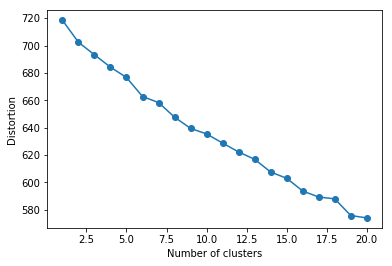

In [26]:
# Kmeans & Elbow Method
from sklearn.cluster import KMeans
distortions = []
for i in range(1, 21):
    km = KMeans(n_clusters=i, init='k-means++',
                n_init=10, max_iter=300, random_state=0)
    km.fit(tfvec)
    distortions.append(km.inertia_)
plt.plot(range(1, 21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
# we see via the elbow method that good clustering is not achieved

In [27]:
# Kmeans prediction of 10 clusters
# not great clustering, but we can visualize
km = KMeans(n_clusters=10, init='k-means++',
            n_init=10, max_iter=300, random_state=0)
km_pred = km.fit_predict(tfvec)

In [28]:
# Dendrogram prep
from scipy.cluster.hierarchy import linkage
row_clusters = linkage(tfvec.toarray(), method='complete', metric='euclidean')
pd.DataFrame(row_clusters, columns=['row label 1', 'row label 2',
                                    'distance', '# of items in cluster'],
                           index=['cluster %d' % (i+1) for i in range(
                                  row_clusters.shape[0])])[:10]

,row label 1,row label 2,distance,# of items in cluster
cluster 1,0.0,177.0,0.0,2.0
cluster 2,32.0,105.0,0.0,2.0
cluster 3,404.0,748.0,0.0,3.0
cluster 4,495.0,749.0,0.0,4.0
cluster 5,529.0,750.0,0.0,5.0
cluster 6,2.0,581.0,0.0,2.0
cluster 7,3.0,562.0,0.0,2.0
cluster 8,4.0,434.0,0.0,2.0
cluster 9,5.0,713.0,0.0,2.0
cluster 10,308.0,311.0,0.0,2.0


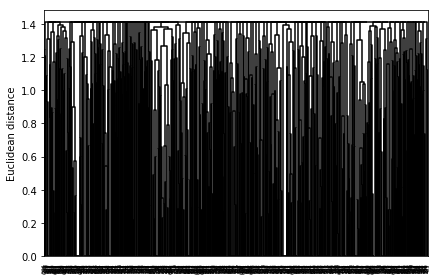

In [29]:
# Dendrogram
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import set_link_color_palette
set_link_color_palette(['black'])
row_dendr = dendrogram(row_clusters, color_threshold=np.inf)

plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()
# we see some root clustering, but again not great clustering

In [30]:
# Agglomerative clustering; 10 clusters
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=10,
                             affinity='euclidean',
                             linkage='complete')
ac_pred = ac.fit_predict(tfvec.toarray())

In [31]:
# DBSCAN
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
db_pred = db.fit_predict(tfvec.toarray())

In [32]:
# to see the count per cluster
unique, counts = np.unique(db_pred, return_counts=True)
print (np.asarray((unique, counts)).T)

[[ -1 641]
 [  0   5]
 [  1   6]
 [  2   5]
 [  3   8]
 [  4   6]
 [  5  12]
 [  6   5]
 [  7   7]
 [  8   7]
 [  9   9]
 [ 10   5]
 [ 11   5]
 [ 12   5]
 [ 13   5]
 [ 14   6]
 [ 15   5]
 [ 16   5]]


### Prediction visualization

In [33]:
# add predictions to visualize
sedit['km_pred'] = km_pred
sedit['ac_pred'] = ac_pred
sedit['db_pred'] = db_pred

sedit.head(2)

,class,phrase,new_phrase,km_pred,ac_pred,db_pred
0,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry 2 wkly comp win cup final may text receive entry txt apply,4,0,-1
1,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,freemsg hey 3 weeks word back like fun still ok xxx std send £ 150,9,0,-1


In [34]:
for i in sedit['km_pred'].unique():
    print (f"K-Means cluster {i} | Number of items: {len(sedit[sedit['km_pred'] == i])}")
    print(str(sedit.iloc[(sedit[sedit['km_pred'] == i][:5].index.values),2])+'\n')

K-Means cluster 4 | Number of items: 51
0     free entry 2 wkly comp win cup final may text receive entry txt apply
4                win cash 100 pounds txt send cost 16 apply reply hl 4 info
22        sunshine quiz wkly win top sony dvd player u know txt 82277 £ 150
46                        ur win £ 200 week weekly quiz text play po box 16
49            day special win £ 1000 quiz take partner send go 150pmsg rcvd
Name: new_phrase, dtype: object

K-Means cluster 9 | Number of items: 255
1                             freemsg hey 3 weeks word back like fun still ok xxx std send £ 150
3     mobile 11 u r entitled update latest colour mobiles camera free call mobile update co free
6                                               use credit click wap link next txt message click
8                          thanks ringtone uk mobile charged £ please replying yes reply charged
14                                                                                           new
Name: new_phrase, dty

In [35]:
for i in sedit['ac_pred'].unique():
    print (f"Agglomerative cluster {i} | Number of items: {len(sedit[sedit['ac_pred'] == i])}")
    print(str(sedit.iloc[(sedit[sedit['ac_pred'] == i][:5].index.values),2])+'\n')

Agglomerative cluster 0 | Number of items: 197
0                                  free entry 2 wkly comp win cup final may text receive entry txt apply
1                                     freemsg hey 3 weeks word back like fun still ok xxx std send £ 150
2        winner valued network customer selected £ 900 prize reward claim call claim code valid 12 hours
3             mobile 11 u r entitled update latest colour mobiles camera free call mobile update co free
9    msg tried call reply sms free nokia mobile free camcorder please call 08000930705 delivery tomorrow
Name: new_phrase, dtype: object

Agglomerative cluster 4 | Number of items: 59
4             win cash 100 pounds txt send cost 16 apply reply hl 4 info
7     england v dont miss news txt ur national 87077 eg england 87077 16
22     sunshine quiz wkly win top sony dvd player u know txt 82277 £ 150
48               call 1 per minute call line access number direct access
49         day special win £ 1000 quiz take partner send 

In [36]:
for i in sedit['db_pred'].unique():
    print (f"DBSCAN cluster {i} | Number of items: {len(sedit[sedit['db_pred'] == i])}")
    print(str(sedit.iloc[(sedit[sedit['db_pred'] == i][:5].index.values),2])+'\n')

DBSCAN cluster -1 | Number of items: 641
0                              free entry 2 wkly comp win cup final may text receive entry txt apply
1                                 freemsg hey 3 weeks word back like fun still ok xxx std send £ 150
2    winner valued network customer selected £ 900 prize reward claim call claim code valid 12 hours
3         mobile 11 u r entitled update latest colour mobiles camera free call mobile update co free
4                                         win cash 100 pounds txt send cost 16 apply reply hl 4 info
Name: new_phrase, dtype: object

DBSCAN cluster 0 | Number of items: 5
21     todays voda numbers ending selected receive 350 award match please call 08712300220 quoting clai...
255    todays voda numbers ending selected receive £ match please call 08712300220 quoting claim code s...
441    todays voda numbers ending selected receive 350 award match please call 08712300220 quoting clai...
625    todays voda numbers ending selected receive £ 350 rewar


DBSCAN cluster 14 | Number of items: 6
273    well 4 costa del sol holiday £ 5000 await collection call 09050090044 toclaim sae tcs pobox334 s...
306    urgent 4 costa del sol holiday £ 5000 await collection call 09050090044 toclaim sae tc pobox334 ...
560    urgent 4 costa del sol holiday £ 5000 await collection call 09050090044 toclaim sae tc pobox334 ...
586    well 4 costa del sol holiday £ 5000 await collection call 09050090044 toclaim sae tcs pobox334 s...
695    4 costa del sol holiday £ 5000 await collection call 09050090044 toclaim sae tc pobox334 stockpo...
Name: new_phrase, dtype: object

DBSCAN cluster 15 | Number of items: 5
308    thanks ringtone order number mobile charged £ 450 tone arrive please call customer services
311    thanks ringtone order number mobile charged £ 450 tone arrive please call customer services
433      thanks ringtone order number mobile charged 450 tone arrive please call customer services
493      thanks ringtone order number mobile charged 450

### Findings

In [37]:
# With DBSCAN, we see some pretty narrow clustering, meaning it can identify very similar items well,
# but has a large unclustered population in cluster -1.
# Modifying the eps and mini_sample parameters can increase the number of clusters

# With K-means, we see pretty loose clustering, meaning the clusters are more general.
# We see some decent word similarities, but the arbitrary 10 clusters is not ideal.

# With Agglomerative, we see a combination of K-means and DBSCAN,
# we see some good narrow clustering, and less effective loose clustering.

In [ ]:
# This concludes part 1.
# In part 2 we can improve pre-processing to improve K-Means / Agglo results
# In part 2 we can expand the number of clusters for DBSCAN
# In part 2 we can improve visualization with cluster centers distance